In [1]:
import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp

In [2]:
from qrao import (
    QuantumRandomAccessEncoding,
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
)

from qrao.utils import get_random_maxcut_qp

[[0. 5. 5. 5. 1. 1. 5. 5. 5. 5. 5. 5. 1. 1.]
 [5. 0. 0. 0. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 5. 5. 0. 5. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 98 x0 + 30 x1 + 20 x2 + 40 x3 + 4 x4 + 4 x5 + 20 x6 + 20 x7 + 20 x8
      + 20 x9 + 20 x10 + 20 x11 + 4 x12 + 4 x13 + [ - 40 x0*x1 - 40 x0*x2
      - 40 x0*x3 - 8 x0*x4 - 8 x0*x5 - 40 x0*x6 - 40 x0*x7 - 40 x0*x8 - 40 x0*x9
      - 40 x0*x10 - 40 x0*x11 - 8 x0*x12 - 8

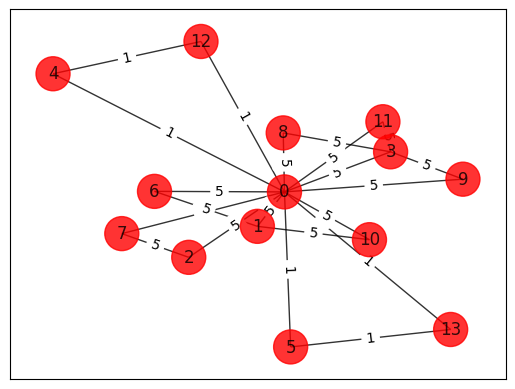

In [3]:
# Generate a random QUBO in the form of a QuadraticProgram
problem = get_random_maxcut_qp(draw=True)
print(problem.export_as_lp_string())

In [4]:
# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian operator
encoding.encode(problem)

# This is our encoded operator
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( 14.999999999999998 * XXIIII
+ 14.999999999999998 * XYIIII
+ 14.999999999999998 * XZIIII
+ 2.9999999999999996 * XIXIII
+ 2.9999999999999996 * XIYIII
+ 14.999999999999998 * XIIXII
+ 14.999999999999998 * XIIYII
+ 14.999999999999998 * XIIZII
+ 14.999999999999998 * XIIIXI
+ 14.999999999999998 * XIIIYI
+ 14.999999999999998 * XIIIZI
+ 2.9999999999999996 * XIIIIX
+ 2.9999999999999996 * XIIIIY
+ 14.999999999999998 * IXIXII
+ 14.999999999999998 * IXIIYI
+ 14.999999999999998 * IYIYII
+ 14.999999999999998 * IZIZII
+ 14.999999999999998 * IZIIXI
+ 14.999999999999998 * IZIIZI
+ 2.9999999999999996 * IIXIIX
+ 2.9999999999999996 * IIYIIY ).

We achieve a compression ratio of (14 binary variables : 6 qubits) ≈ 2.3333333333333335.



In [21]:
# Create a QuantumInstance for solving the relaxed Hamiltonian using VQE
relaxed_qi = QuantumInstance(backend=Aer.get_backend("aer_simulator"), shots=1024)

# Set up the variational quantum eigensolver (ansatz width is determined by the encoding)
qaoa = QAOA(optimizer = SPSA(maxiter=50),
            quantum_instance = relaxed_qi)

# qaoa = QAOA(
#     ansatz=RealAmplitudes(encoding.num_qubits),
#     optimizer=SPSA(maxiter=50),
#     quantum_instance=relaxed_qi,
# )

# Use semideterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
rounding_scheme = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(
    encoding=encoding, min_eigen_solver=qaoa
)

In [22]:
# Solve the optimization problem
results = qrao.solve(problem)
qrao_fval = results.fval
print(results)

fval=44.0, x0=0, x1=0, x2=1, x3=0, x4=0, x5=1, x6=0, x7=1, x8=0, x9=0, x10=1, x11=0, x12=0, x13=1, status=SUCCESS


In [23]:
# relaxed function value
results.relaxed_fval

72.36328125

In [24]:
# optimal function value
results.fval

44.0

In [25]:
# optimal value
results.x

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1])

In [26]:
print(
    f"The obtained solution places a partition between nodes {np.where(results.x == 0)[0]} "
    f"and nodes {np.where(results.x == 1)[0]}."
)

The obtained solution places a partition between nodes [ 0  1  3  4  6  8  9 11 12] and nodes [ 2  5  7 10 13].


In [27]:
# pylint: disable=wrong-import-order
from qiskit_optimization.algorithms import CplexOptimizer

cplex_optimizer = CplexOptimizer()
cplex_results = cplex_optimizer.solve(problem)
exact_fval = cplex_results.fval

cplex_results

<OptimizationResult: fval=128.0, x0=1.0, x1=1.0, x2=0.0, x3=1.0, x4=0.0, x5=0.0, x6=0.0, x7=0.0, x8=0.0, x9=0.0, x10=0.0, x11=0.0, x12=0.0, x13=0.0, status=SUCCESS>

In [28]:
approximation_ratio = qrao_fval / exact_fval
print("QRAO Approximate Optimal Function Value:", qrao_fval)
print("Exact Optimal Function Value:", exact_fval)
print(f"Approximation Ratio: {approximation_ratio:.2f}")

QRAO Approximate Optimal Function Value: 44.0
Exact Optimal Function Value: 128.0
Approximation Ratio: 0.34
